# Analisis Sentimen Terhadap Game **Solo Leveling:Arise**

Kita akan melakukan analisis sentimen pada review di game bernama **[Solo Leveling:Arise](https://play.google.com/store/search?q=solo+leveling)**. Kita sudah melakuan scraping pada data review sebelumnya di `scraping.ipynb` dan mendapatkan review lebih dari 20 ribu data.

## **Import Library**

In [1]:
import re
import csv
import string
import swifter
import requests
from io import StringIO

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from wordcloud import WordCloud

pd.options.mode.copy_on_write = True

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## **Data Wrangling**

### Gathering

In [2]:
df = pd.read_csv('dataset/solev-reviews.csv')
df

,score,review
0,3,"Dari segi game play nya sudah ok lah, dari seg..."
1,4,loadingnya lama banget sampqi 9 jam padahal sa...
2,1,"Masih sering terjadi bug loading screen, yang ..."
3,3,game nya bagus pertandingannya bagus namun ada...
4,5,Masih ada beberapa bug dimana terkadang bos me...
...,...,...
27425,1,👎👎👎👎👎👎
27426,1,👎👎👎👎👎👎👎👎👎👎👎👎👎👎👎👎👎
27427,1,🥴🥴
27428,1,😡😡😡😡😡😡😡


> 🗿

### Assessing

In [3]:
df.shape

(27430, 2)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27430 entries, 0 to 27429
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   score   27430 non-null  int64 
 1   review  27430 non-null  object
dtypes: int64(1), object(1)
memory usage: 428.7+ KB


In [5]:
df.describe(include='all')

,score,review
count,27430.000000,27430
unique,NaN,22969
top,NaN,mantap
freq,NaN,441
mean,3.206526,NaN
std,1.726549,NaN
min,1.000000,NaN
25%,1.000000,NaN
50%,3.000000,NaN
75%,5.000000,NaN


In [6]:
df.isna().sum()

,0
score,0
review,0


Tidak ada data yang hilang.

In [7]:
df.duplicated().sum()

4200

Terdapat **4200 baris** yang duplikat. Tetapi kita akan membiarkannya saja karena Google membatasi 1 kali review pada setiap akun.

#### Insight:
- Terdapat **27430 baris** (review).
- Tidak ada data yang hilang.
- Terdapat baris duplikat tapi kita akan biarkan saja.

### Cleaning

Tidak ada yang perlu dibersihkan.

## **EDA**

### Preprocessing

In [9]:
df[df.score == 1].review.tail(20)

,review
27003,Sampah
27004,Berat
27005,BOOOORING
27006,jeleg
27007,loading
27008,Lag
27009,Jelek
27010,Bugggggg
27011,Jelek
27012,burik


Terlihat bahwa ada reviewer yang menggunakan emoji, serta kata dengan huruf beurlang didalamnya.

Kita akan mendefinisikan fungsi kita terlebih dahulu supaya lebih mudah dibaca dan dibuat.

In [10]:
stemmer = StemmerFactory().create_stemmer()

# convert long word and emoji
def convert(text):
    text = re.sub(r'[👎🤣🥴😡🗿🤢🤮🥱😪🤪😵😜😛😝]+', 'jelek', text)
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    return text

# cleaning text
def clean(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'RT[\s]', '', text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)

    text = text.replace('\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip(' ')
    return text

# convert to lower case
def fold(text):
    return text.lower()

# tokenize text into array
def tokenize(text):
    return word_tokenize(text)

# fix slang words into original form
def fixslang(words):
    fixed_words = []
    for word in words:
        if word in slangwords:
            fixed_words.append(slangwords[word])
        else:
            fixed_words.append(word)

    return fixed_words

# stopword removal
def filter(words):
    stopword_list = set(stopwords.words('indonesian'))
    stopword_list.update(set(stopwords.words('english')))
    stopword_list.update(['iya','yaa','nya','na','sih','ku',"di","ya","loh","kah","woi","woy", 'deh'])

    filtered = []
    for word in words:
        if word not in stopword_list:
            filtered.append(word)

    return filtered

# combine the words into sentence
def combine(words):
    return ' '.join(words)

# return word into original form
def stem(text):
    return stemmer.stem(text)

In [11]:
slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "plisss": "tolong", "bgttt": "banget", "indo": "indonesia", "bgtt": "banget", "ad": "ada", "rv": "redvelvet", "plis": "tolong", "pls": "tolong", "cr": "sumber", "cod": "bayar ditempat", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin"}
slangwords.update({
    'g' : 'tidak', 'gk': 'tidak', 'ga': 'tidak', 'gak': 'tidak', 'nga': 'tidak', 'ngak': 'tidak', 'freze': 'berhenti', 'freeze': 'berhenti',
    'stuck': 'berhenti', 'ngestuck': 'berhenti', 'stuk': 'berhenti', 'loading': 'memuat', 'ngelag': 'lag', 'ap': 'apa', 'dg': 'dong', 'bnyak': 'banyak',
    'bnyk': 'banyak', 'ngebug': 'eror', 'screen': 'layar', 'bs': 'bisa', 'bsa': 'bisa', 'msuk': 'masuk', 'msk': 'masuk', 'skil': 'kemampuan',
    'f2p': 'gratis', 'p2w': 'bayar', 'error': 'eror', 'device': 'perangkat', 'diem': 'diam', 'cape': 'lelah', 'capek': 'lelah', 'bagu': 'bagus',
    'udh': 'udah', 'bugnya': 'eror', 'black': 'hitam', 'pencet': 'tekan', 'bug': 'eror'
})

In [12]:
df_cleaned = df[['review']]
df_cleaned['converted'] = df_cleaned.review.apply(convert)
df_cleaned['cleaned']   = df_cleaned.converted.apply(clean)
df_cleaned['folded']    = df_cleaned.cleaned.apply(fold)
df_cleaned['tokenized'] = df_cleaned.folded.apply(tokenize)
df_cleaned['fixed']     = df_cleaned.tokenized.apply(fixslang)
df_cleaned['filtered']  = df_cleaned.fixed.apply(filter)
df_cleaned['combined']  = df_cleaned.filtered.apply(combine)
df_cleaned["stemmed"]   = df_cleaned.combined.swifter.apply(stem)

Pandas Apply:   0%|          | 0/27430 [00:00<?, ?it/s]

In [13]:
df_cleaned

,review,converted,cleaned,folded,tokenized,fixed,filtered,combined,stemmed
0,"Dari segi game play nya sudah ok lah, dari seg...","Dari segi game play nya sudah ok lah, dari seg...",Dari segi game play nya sudah ok lah dari segi...,dari segi game play nya sudah ok lah dari segi...,"[dari, segi, game, play, nya, sudah, ok, lah, ...","[dari, segi, game, play, nya, sudah, ok, lah, ...","[segi, game, play, ok, segi, tingkat, kesulita...",segi game play ok segi tingkat kesulitan lumay...,segi game play ok segi tingkat sulit lumayan a...
1,loadingnya lama banget sampqi 9 jam padahal sa...,loadingnya lama banget sampqi 9 jam padahal sa...,loadingnya lama banget sampqi jam padahal say...,loadingnya lama banget sampqi jam padahal say...,"[loadingnya, lama, banget, sampqi, jam, padaha...","[loadingnya, lama, banget, sampqi, jam, padaha...","[loadingnya, banget, sampqi, jam, bagus, wifin...",loadingnya banget sampqi jam bagus wifinya kas...,loadingnya banget sampqi jam bagus wifinya kas...
2,"Masih sering terjadi bug loading screen, yang ...","Masih sering terjadi bug loading screen, yang ...",Masih sering terjadi bug loading screen yang d...,masih sering terjadi bug loading screen yang d...,"[masih, sering, terjadi, bug, loading, screen,...","[masih, sering, terjadi, eror, memuat, layar, ...","[eror, memuat, layar, dimana, menggangu, login...",eror memuat layar dimana menggangu login ulang...,eror muat layar mana menggangu login ulang lay...
3,game nya bagus pertandingannya bagus namun ada...,game nya bagus pertandingannya bagus namun ada...,game nya bagus pertandingannya bagus namun ada...,game nya bagus pertandingannya bagus namun ada...,"[game, nya, bagus, pertandingannya, bagus, nam...","[game, nya, bagus, pertandingannya, bagus, nam...","[game, bagus, pertandingannya, bagus, eror, di...",game bagus pertandingannya bagus eror dimana m...,game bagus tanding bagus eror mana selesai tug...
4,Masih ada beberapa bug dimana terkadang bos me...,Masih ada beberapa bug dimana terkadang bos me...,Masih ada beberapa bug dimana terkadang bos me...,masih ada beberapa bug dimana terkadang bos me...,"[masih, ada, beberapa, bug, dimana, terkadang,...","[masih, ada, beberapa, eror, dimana, terkadang...","[eror, dimana, terkadang, bos, menghilangmemil...",eror dimana terkadang bos menghilangmemiliki d...,eror mana terkadang bos menghilangmemiliki def...
...,...,...,...,...,...,...,...,...,...
27425,👎👎👎👎👎👎,jelek,jelek,jelek,[jelek],[jelek],[jelek],jelek,jelek
27426,👎👎👎👎👎👎👎👎👎👎👎👎👎👎👎👎👎,jelek,jelek,jelek,[jelek],[jelek],[jelek],jelek,jelek
27427,🥴🥴,jelek,jelek,jelek,[jelek],[jelek],[jelek],jelek,jelek
27428,😡😡😡😡😡😡😡,jelek,jelek,jelek,[jelek],[jelek],[jelek],jelek,jelek


Karena proses stem yang lama hingga **20 menit** walaupun sudah menggunakan Google Colab, saya akan menyimpan hasilnya pada file csv baru.

In [14]:
with open('dataset/solev-reviews-cleaned.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(df_cleaned.columns)
    writer.writerows(df_cleaned.values)

Selanjutnya kita tentukan apakah setiap review bersifat positif atau negatif.

In [15]:
lexicon_positive = dict()
lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
if response.status_code == 200:
    for row in csv.reader(StringIO(response.text), delimiter=','):
        lexicon_positive[row[0]] = int(row[1])
    print(len(lexicon_positive))
else:
    print("Gagal mengambil lexicon positif")

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
if response.status_code == 200:
    for row in csv.reader(StringIO(response.text), delimiter=','):
        lexicon_negative[row[0]] = int(row[1])
    print(len(lexicon_negative))
else:
    print("Gagal mengambil lexicon negatif")

3609
6607


Kita tambahkan lexicon kita sendiri juga. Untuk yang positif kita akan membuat nilainya sedikit lebih tinggi daripada negatif, karena dalam review mungkin orang hanya menambahkan 1 kata positif tapi ada beberapa kata negatif.

In [16]:
lexicon_positive.update({
    'bagus': 2, 'mantap': 2, 'keren': 1, 'grafik': 2, 'seru': 2, 'cocok': 1, 'senang': 2, 'pukau': 3, 'ringan': 1, 'gila': 2, 'ok': 1, 'baik': 3
})

lexicon_negative.update({
    'henti': -2, 'lag': -2, 'masalah': -2, 'jaring': -1, 'aneh': -2, 'error': -1, 'eror': -1, 'layar': -2, 'screen': -1, 'fix': -1
})

In [17]:
def analysis(text):
    score = 0

    for word in text.split():
        score += lexicon_positive.get(word, 0)
        score += lexicon_negative.get(word, 0)

    status = 'positif' if score >= 0 else 'negatif'
    return score, status

In [18]:
results = df_cleaned.stemmed.apply(analysis)
results = list(zip(*results))

df_scored = df_cleaned.copy()
df_scored['score'] = results[0]
df_scored['status'] = results[1]
df_scored['status'].value_counts()

,count
status,
positif,14617
negatif,12813


### Visualizing

Kita lihat bagaimana persebaran sentimen pada data seluruh data review.

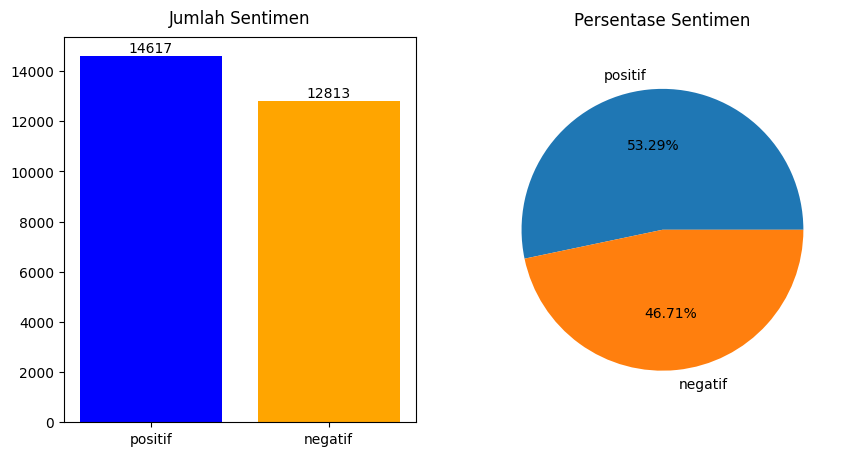

In [19]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))

value_counts = df_scored['status'].value_counts()

ax[0].bar(value_counts.index, value_counts, color=['blue', 'orange', 'green'])
ax[0].set_title('Jumlah Sentimen', pad=10)
for i, count in enumerate(value_counts):
    ax[0].text(i, count, count, ha='center', va='bottom')

ax[1].pie(x=value_counts, labels=value_counts.index, autopct='%.2f%%')
ax[1].set_title('Persentase Sentimen', pad=20)

plt.show()

Dapat dilihat bahwa sentimen positif dengan persentase `53.29%` yang mana lebih banyak dari pada sentimen negatif dengan persentase `46.71%`.

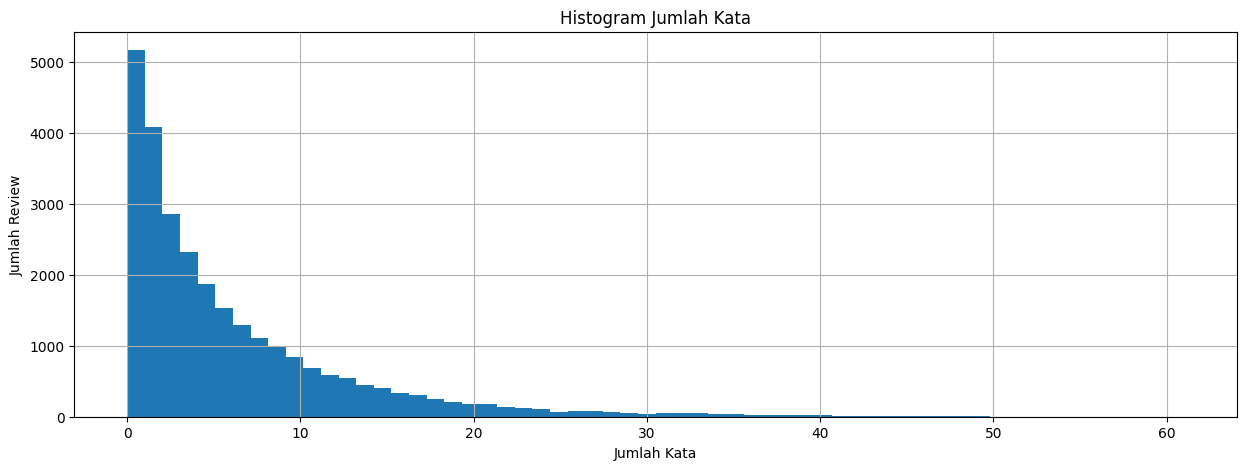

In [20]:
df_scored.stemmed.apply(lambda x: len(x.split())).hist(bins=60, figsize=[15, 5])
plt.xlabel('Jumlah Kata')
plt.ylabel('Jumlah Review')
plt.title('Histogram Jumlah Kata')
plt.show()

Bisa dilihat dari grafik tersebut bahwa mayoritas review memiliki 1 sampai 10 kata.

In [21]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_scored.stemmed)
df_tfidf = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

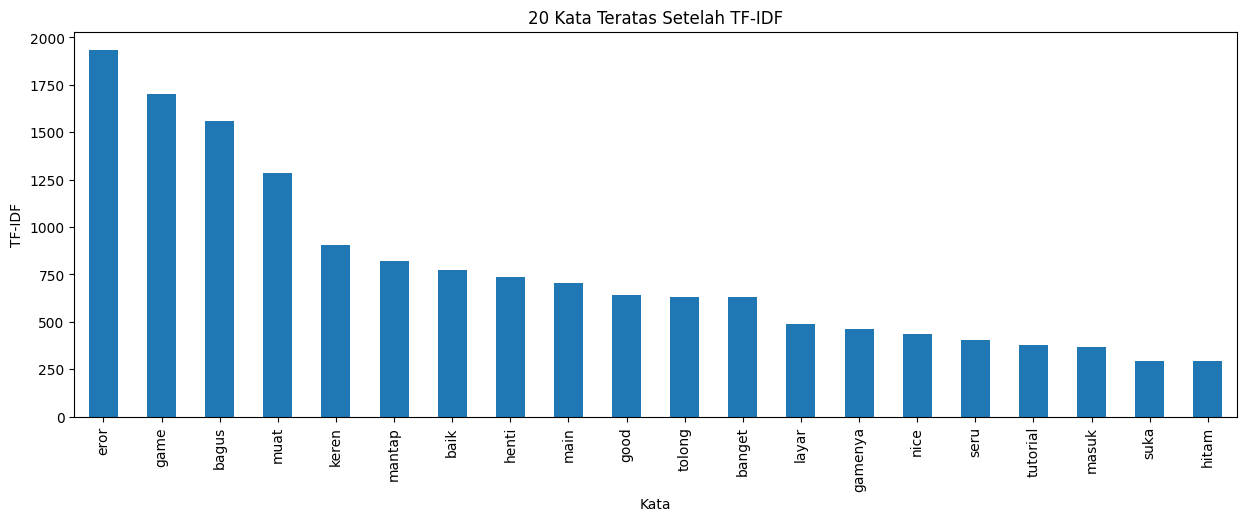

In [22]:
df_tfidf.sum().sort_values(ascending=False).head(20).plot(kind='bar', figsize=[15,5])
plt.xlabel('Kata')
plt.ylabel('TF-IDF')
plt.title('20 Kata Teratas Setelah TF-IDF')
plt.show()

Terdapat beberapa kata yang memiliki nilai total TF-IDF tinggi, mulai dari bug yang paling tinggi, game, bagus, dan muat.

In [23]:
def wordcloud(status):
    words = ''
    df_selected = df_scored[df_scored.status == status]

    for text in df_scored[df_scored.status == status].stemmed:
        words += ' ' + text

    plt.figure(figsize=[16, 5])

    ax = plt.subplot(1, 2, 1)
    ax.imshow(WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(words))
    ax.axis('off')

    ax = plt.subplot(1, 2, 2)
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(df_selected.stemmed)
    df_selected_tfidf = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
    df_selected_tfidf.sum().sort_values(ascending=False).head(10).plot(kind='bar', ax=ax)
    ax.set_xlabel('Kata')
    ax.set_ylabel('TF-IDF')

    plt.show()

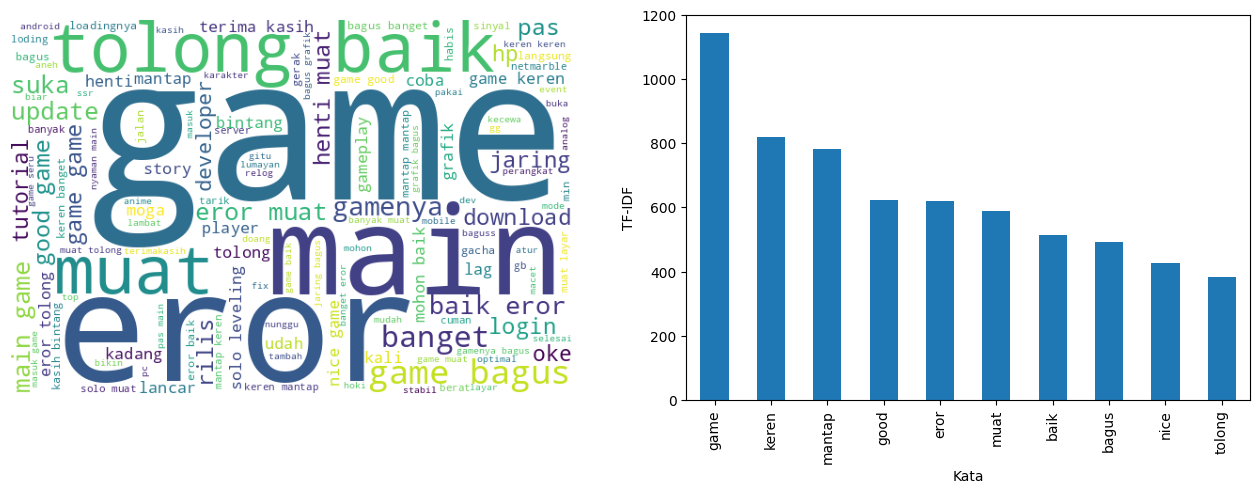

In [24]:
wordcloud('positif')

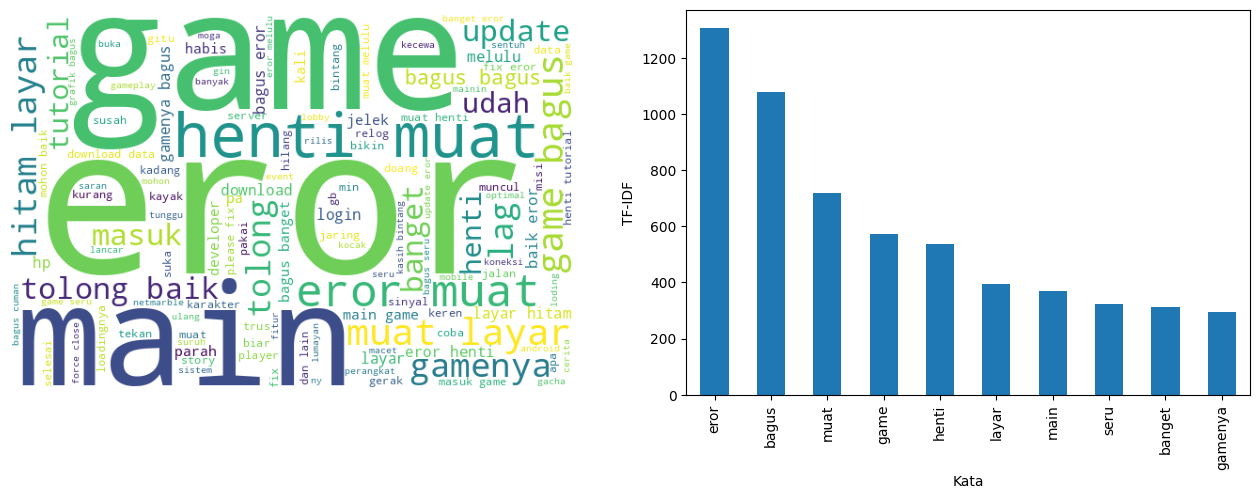

In [25]:
wordcloud('negatif')

Dilihat dari beberapa visual status diatas kita bisa lihat bahwa:
- Sentimen positif memiliki banyak sekali kata pujian di dalam reviewnya, seperti `mantap`, `keren`, dan sebagainya.
- Sentimen negatif memiliki banyak sekali kata yang berkaitan dengan masalah teknis, seperti `eror`, `muat` (loading), `henti` (stuck), dan sebagainya.
- Anehnya sentimen negatif memiliki banyak kata positif, yang menunjukkan bahwa review negatif mungkin memuji terlebih dahulu lalu mengkritiknya.

## **Modeling**

Terakhir kita akan membuat model dengan beberapa model yang ada.

In [26]:
X = df_scored.stemmed
y = df_scored.status.apply(lambda x: int(x == 'positif'))

In [27]:
tfidf      = TfidfVectorizer(max_features=600, min_df=30, max_df=0.8)
X_tfidf    = tfidf.fit_transform(X)
df_feature = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

In [28]:
df_feature

,admin,ah,ajg,akun,alam,alami,alur,always,aman,ambil,...,upgrade,user,utama,versi,wajar,wifi,win,world,wow,yah
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27425,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27426,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27427,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27428,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=0)
print(f"Training set shape : X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Test set shape     : X_test={X_test.shape}, y_test={y_test.shape}")

Training set shape : X_train=(21944, 600), y_train=(21944,)
Test set shape     : X_test=(5486, 600), y_test=(5486,)


In [30]:
all_score = {}
all_model = {}
def predict(model):
    model = model.fit(X_train.toarray(), y_train)
    score = {
        'train': accuracy_score(model.predict(X_train), y_train),
        'test' : accuracy_score(model.predict(X_test), y_test)
    }

    return score, model

In [31]:
score, model = predict(KNeighborsClassifier(n_neighbors=5))
all_score['knn'] = score
all_model['knn'] = model
score

{'train': 0.8358549033904484, 'test': 0.7909223477943857}

In [32]:
score, model = predict(DecisionTreeClassifier())
all_score['dt'] = score
all_model['dt'] = model
score

{'train': 0.9922074371126504, 'test': 0.8570907765220561}

In [33]:
score, model = predict(RandomForestClassifier())
all_score['rf'] = score
all_model['rf'] = model
score

{'train': 0.9922074371126504, 'test': 0.8878964637258476}

In [34]:
score, model = predict(BernoulliNB())
all_score['nb'] = score
all_model['nb'] = model
score

{'train': 0.7647648559970834, 'test': 0.7473569084943492}

In [35]:
score, model = predict(LogisticRegression())
all_score['lr'] = score
all_model['lr'] = model
score

{'train': 0.9426722566532993, 'test': 0.9345606999635435}

In [36]:
pd.DataFrame(all_score, index=['train', 'test'])

,knn,dt,rf,nb,lr
train,0.835855,0.992207,0.992207,0.764765,0.942672
test,0.790922,0.857091,0.887896,0.747357,0.934561


Bisa dilihat bahwa model logistic memiliki skor akurasi paling tinggi pada data training dan data test yaitu mencapai `93%`. Oleh karena itu kita akan menggunakan model tersebut.

## **Testing (Inference)**

In [37]:
def predict_text(text):
    text_converted = convert(text)
    text_cleaned   = clean(text_converted)
    text_folded    = fold(text_cleaned)
    text_tokenized = tokenize(text_folded)
    text_fixed     = fixslang(text_tokenized)
    text_filtered  = filter(text_fixed)
    text_combined  = combine(text_filtered)
    text_stemmed   = stem(text_combined)

    X_new_text = tfidf.transform([text_stemmed])
    y_pred = all_model['lr'].predict(X_new_text.toarray())
    return y_pred

In [38]:
text_list = [
    'Game yang mantap!',
    'banyak bug dan error pada loading screen',
    'Bagus dan seru, tapi tolong diperbaiki lagi bug nya!',
    'keren grafiknya bagus genshin kalah',
    'semenjak update sering terjadi bug :('
]

for text in text_list:
    print('Sentimen: ', '+POSITIF' if predict_text(text) == 1 else '-NEGATIF')

Sentimen:  +POSITIF
Sentimen:  -NEGATIF
Sentimen:  -NEGATIF
Sentimen:  +POSITIF
Sentimen:  -NEGATIF


In [39]:
text = input("Masukkan review baru: ")
print('Hasil prediksi adalah: ', '+POSITIF' if predict_text(text) == 1 else '-NEGATIF')

Masukkan review baru: tolong developer perbaiki bug yang ada karena ini game yang sangat bagus
Hasil prediksi adalah:  +POSITIF
